In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score,average_precision_score, recall_score, f1_score,precision_recall_curve, auc, classification_report, confusion_matrix, make_scorer, fbeta_score
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN


In [42]:
df_train=pd.read_csv('../data/output/development_sample_cleaned_1.csv')
df_test=pd.read_csv('../data/output/testing_sample_cleaned.csv')

In [43]:
df_train = df_train.drop(['ID', 'customer_id'], axis=1)
df_test = df_test.drop(['ID', 'customer_id'], axis=1)

In [5]:
# Separate features and target variable
X = df_train.drop('target', axis=1)
y = df_train['target']


In [46]:
X_t = df_test.drop('target', axis=1)
y_t = df_test['target']

In [27]:
oversamplers = {
    'SMOTE': SMOTE(random_state=123),
    'RandomOverSampler': RandomOverSampler(random_state=123),
    'ADASYN': ADASYN(random_state=123)
}

# Define the parameters for GridSearchCV
param_grid = {
    'C': [0.9, 1, 1.1],
    'penalty': ['l1','l2'],
    'solver': ['liblinear','saga'],
    # set class weight
    'class_weight': [None, {0: 0.45, 1:0.55}]
}

In [38]:
def pr_auc_score(y_true, y_pred):
    # Compute PR_AUC using average_precision_score
    pr_auc = average_precision_score(y_true, y_pred)
    return pr_auc

# Create a scorer from the custom scoring function
pr_auc_scorer = make_scorer(pr_auc_score)




In [28]:
f05_scorer = make_scorer(fbeta_score, beta=2)


Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best Parameters for SMOTE: {'C': 1.1, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}

Model Specifications and Validation F05-score for SMOTE:
   param_C param_penalty param_solver  param_class_weight  mean_test_score  \
16     1.1            l1    liblinear                None         0.804103   
8        1            l1    liblinear                None         0.804103   
17     1.1            l1         saga                None         0.804103   
1      0.9            l1         saga                None         0.804102   
9        1            l1         saga                None         0.804102   
0      0.9            l1    liblinear                None         0.804099   
18     1.1            l2    liblinear                None         0.804092   
10       1            l2    liblinear                None         0.804091   
19     1.1            l2         saga                None         0.804090   


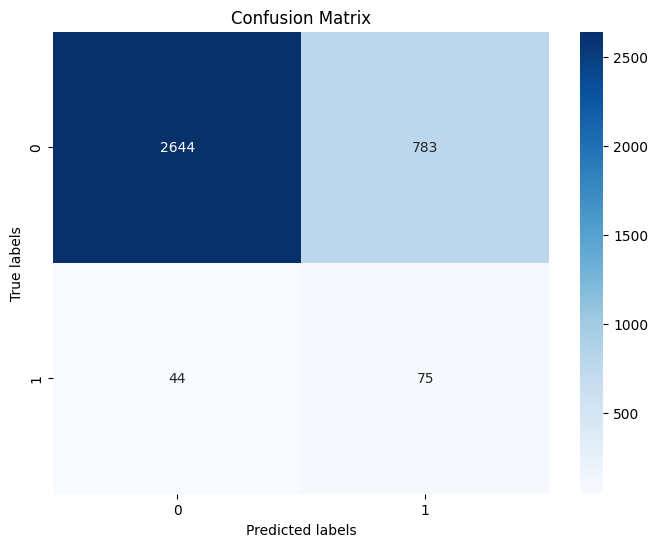

Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best Parameters for RandomOverSampler: {'C': 1, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'}

Model Specifications and Validation F05-score for RandomOverSampler:
   param_C param_penalty param_solver  param_class_weight  mean_test_score  \
9        1            l1         saga                None         0.802970   
17     1.1            l1         saga                None         0.802969   
1      0.9            l1         saga                None         0.802968   
16     1.1            l1    liblinear                None         0.802966   
8        1            l1    liblinear                None         0.802966   
0      0.9            l1    liblinear                None         0.802966   
19     1.1            l2         saga                None         0.802960   
18     1.1            l2    liblinear                None         0.802959   
11       1            l2         saga                None    

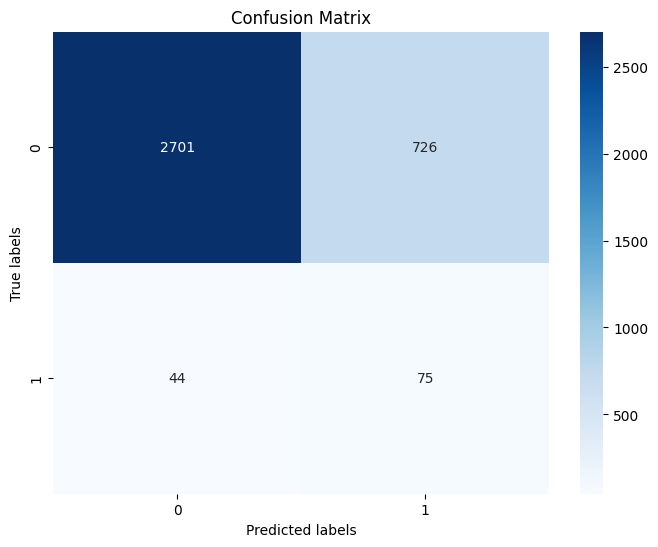

Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best Parameters for ADASYN: {'C': 0.9, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'}

Model Specifications and Validation F05-score for ADASYN:
   param_C param_penalty param_solver  param_class_weight  mean_test_score  \
1      0.9            l1         saga                None         0.765305   
9        1            l1         saga                None         0.765305   
0      0.9            l1    liblinear                None         0.765305   
17     1.1            l1         saga                None         0.765305   
16     1.1            l1    liblinear                None         0.765305   
8        1            l1    liblinear                None         0.765304   
19     1.1            l2         saga                None         0.765292   
18     1.1            l2    liblinear                None         0.765291   
11       1            l2         saga                None         0.765290   
10 

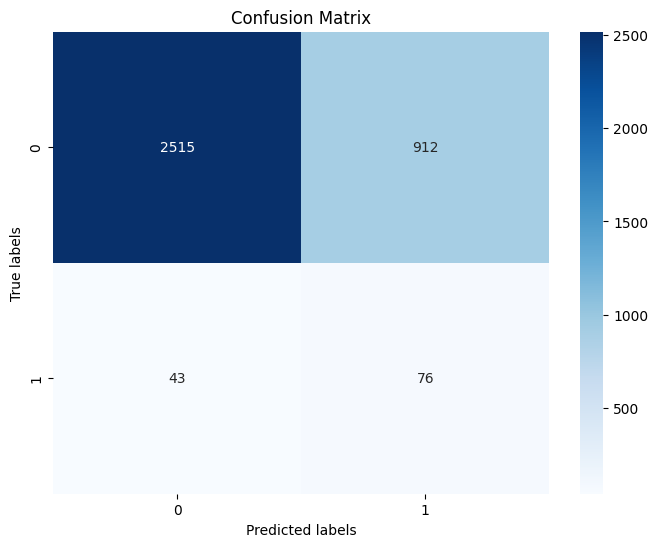


Combined Results for all Oversamplers:
     SMOTE                                                                 \
   param_C param_penalty param_solver  param_class_weight mean_test_score   
16     1.1            l1    liblinear                None        0.804103   
8        1            l1    liblinear                None        0.804103   
17     1.1            l1         saga                None        0.804103   
1      0.9            l1         saga                None        0.804102   
9        1            l1         saga                None        0.804102   
0      0.9            l1    liblinear                None        0.804099   
18     1.1            l2    liblinear                None        0.804092   
10       1            l2    liblinear                None        0.804091   
19     1.1            l2         saga                None        0.804090   
2      0.9            l2    liblinear                None        0.804089   
11       1            l2         sag

In [48]:
log_reg = LogisticRegression(random_state=123, max_iter=1000)  # Increase max_iter

# Create a dictionary to store results for each oversampler
results_dict = {}
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_t_scaled = scaler.transform(X_t)

for name, oversampler in oversamplers.items():
    # Upsample the minority class using the current oversampler
    X_resampled, y_resampled = oversampler.fit_resample(X_train_scaled, y_train)

    # Initialize GridSearchCV with verbose for detailed progress
    grid_search = GridSearchCV(log_reg, param_grid, cv=3, scoring='average_precision', n_jobs=-1, verbose=4)

    # Fit GridSearchCV on the training data
    grid_search.fit(X_resampled, y_resampled)

    # Get the best parameters
    best_params = grid_search.best_params_
    print(f"\nBest Parameters for {name}:", best_params)

    # Store results in dictionary
    results = pd.DataFrame(grid_search.cv_results_)
    cols_to_keep = ['param_C', 'param_penalty', 'param_solver', 'param_class_weight', 'mean_test_score', 'std_test_score']
    results_table = results[cols_to_keep].sort_values(by='mean_test_score', ascending=False)
    results_dict[name] = results_table

    # Get the best performing model
    best_log_reg = LogisticRegression(**best_params, random_state=123, max_iter=1000)  # Increase max_iter
    best_log_reg.fit(X_resampled, y_resampled)


    # Make predictions on the test set
    y_pred = best_log_reg.predict(X_t_scaled)    
    # Print the table for the current oversampler
    print(f"\nModel Specifications and Validation F05-score for {name}:")
    print(results_table)

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_t, y_pred))

    cm = confusion_matrix(y_t, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
# Combine results for all oversamplers into a single table
combined_results = pd.concat(results_dict, axis=1)

# Print the combined results
print("\nCombined Results for all Oversamplers:")
print(combined_results)
